In [1]:
import methyltree 
import pandas as pd
import scanpy as sc
import os
import numpy as np
from matplotlib import pyplot as plt
import cospar as cs
cs.settings.set_figure_params()
pd.options.display.max_rows = 100

# Instruction

The demo data is stored in the `raw_data` folder, which contains the cell-by-region methylation rate values in `raw_data/DARLIN_HSC/test_data.tsv.gz`
and the annotation for each cell_id `sample_sheet.tsv.gz`. 

# Load the methylation rate data and generate annadata

In [2]:
current_directory =os.getcwd()

print('Run test data') # The test data is a subsampled dataset from our DARLIN paper, associated with LL731 mouse.

df_new2=pd.read_csv('raw_data/DARLIN_HSC/test_data.tsv.gz',compression='gzip',sep='\t').rename(columns={'cell_id':'index'})
print(df_new2.head())

df_out=df_new2.pivot(index='index',columns='genomic_region_id',values='value')
adata=sc.AnnData(df_out) #This adata has not annotation yet. We will use the df_sample from raw_data folder to annotate this object later


data_path='raw_data/DARLIN_HSC' # this path has the sample_sheet.tsv.gz file, which contains all the annotations
out_dir='data/data'
save_data_des=None
clone_key='large_clone_id'

adata

Run test data
             index          genomic_region_id  value
0  LL731_P1_DNA_A6  chr10_100008499_100010500   83.0
1  LL731_P1_DNA_B3  chr10_100008499_100010500   67.0
2  LL731_P1_DNA_C5  chr10_100008499_100010500   67.0
3  LL731_P1_DNA_C6  chr10_100008499_100010500   67.0
4  LL731_P1_DNA_D8  chr10_100008499_100010500   60.0


AnnData object with n_obs × n_vars = 71 × 107383

In [3]:
data_des='test_data'
figure_path='data/figure'
os.makedirs(out_dir,exist_ok=True)
os.makedirs(figure_path,exist_ok=True)

In [4]:
df_sample=methyltree.hf.load_sample_info(data_path)
df_sample.head()

,sample,lineage,stage,nCG,met_rate,nGC,corr_met,shared_sites,HQ,celltype,UMAP_rna_x,UMAP_rna_y,large_clone_id,inferred_clones
0,LL731_P1_DNA_A1,BM_HSC_0,BM_HSC_0,1578270.0,0.766563,14385539.0,0.916792,41.0,True,BM_HSC_0,13.722864,13.104034,clone_18,clone_12
1,LL731_P1_DNA_A4,BM_HSC_0,BM_HSC_0,1581872.0,0.774810,14395691.0,0.915121,41.0,True,BM_HSC_0,11.456920,12.274448,clone_25,clone_0
2,LL731_P1_DNA_A6,BM_HSC_0,BM_HSC_0,1443080.0,0.770401,13109403.0,0.912740,41.0,True,BM_HSC_0,11.788898,13.383047,clone_22,clone_26
3,LL731_P1_DNA_A8,BM_HSC_0,BM_HSC_0,1281389.0,0.767704,11669548.0,0.911345,41.0,True,BM_HSC_0,14.298115,14.677113,clone_0,clone_8
4,LL731_P1_DNA_A10,BM_HSC_1,BM_HSC_1,1067036.0,0.773752,9728259.0,0.915459,41.0,True,BM_HSC_1,16.718924,14.012350,clone_5,clone_5


# MethyTree analysis

This function will merge the df_sample and adata together because update_sample_info=True. This is our main function.

Module:

1, Data loading

2, X_similarity correction to remove noise (`similarity_correction=True`)

3, X_similarity z-score to enhance lineage signal
    (`remove_celltype_signal=False`)

4, Lineage tree inference or cell state ordering
    (`order_method=['NJ','UPGMA','HierarchicalClustering']`)

5, Improve lineage tree with stochastic optimization
    (`optimize_tree=False,optimize_background_cutoff=0.8`)

6, Identify putative clones with thresholding. Very simple. Not very well.
    (`identify_clones=False,InfClone_threshold=0.5,InfClone_signal_noise=True`)

7, Clean up ordered_clone_array and compute lineage accuracy

8, Visualize the X_similarity
    (`replot_similarity_matrix=False`)

9, Memory analysis

10, Coarse-grain analysis (not as good as the pseudo-cell analysis)

11, Accuracy by depth

use provided adata
adata shape:  (71, 107383)
update sample
X_similarity_correlation_raw not found in adata.obsm
re-compute similarity matrix
Use correlation for similarity
duration: 40.9082670211792
correct similarity: outer loop 0;  current epsilon 0.05
Use fast/analytical correction method


  0%|          | 4/1000 [00:00<00:00, 1176.77it/s]


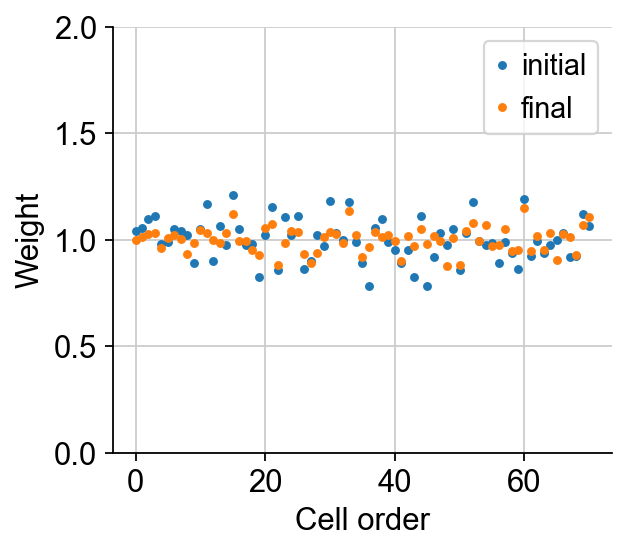

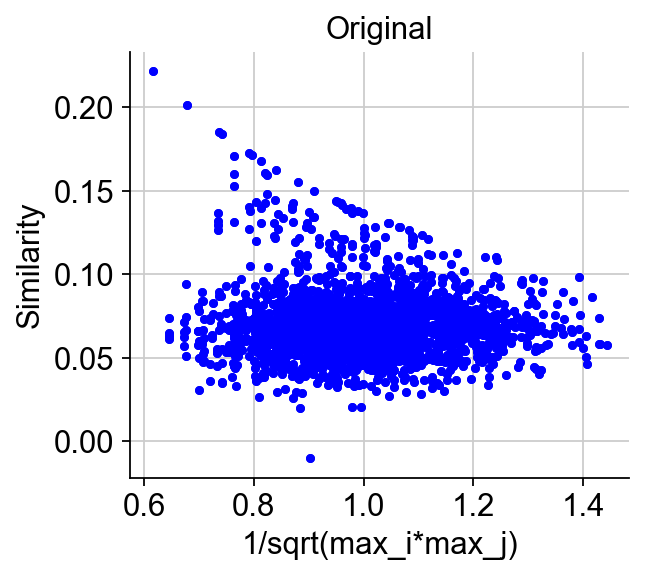

std: 0.015


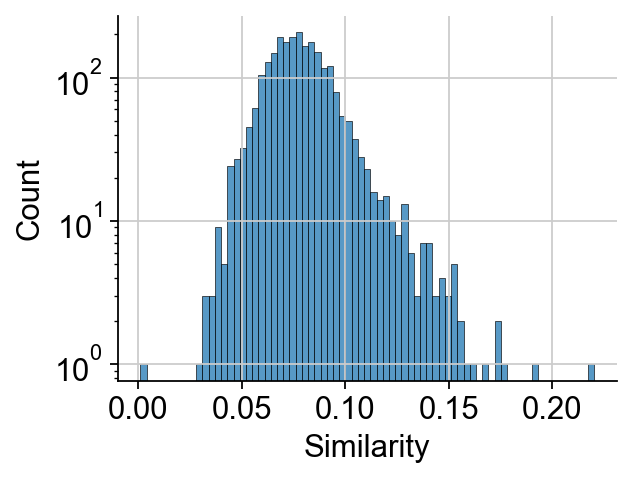

Reconstruction method: UPGMA
      clone  clone_size  accuracy  continuity  entropy  wassertein  \
0   clone_0          12  0.833333    0.833333  0.22781    0.166667   
1   clone_1           8  1.000000    1.000000  0.00000    0.000000   
2  clone_10           3  1.000000    1.000000  0.00000    0.000000   
3  clone_11           2  1.000000    1.000000  0.00000    0.000000   
4  clone_12           2  1.000000    1.000000  0.00000    0.000000   

   random_accuracy  random_continuity  random_entropy  random_wassertein  
0              0.2           0.275000        0.886053           0.641667  
1              0.2           0.250000        0.908333           0.587500  
2              0.0           0.333333        1.000000           0.666667  
3              0.1           0.550000        0.900000           0.450000  
4              0.2           0.600000        0.800000           0.400000  
mean continuity: 0.9682539682539684
mean accuracy: 0.9444444444444445
mean entropy: 0.05846712666551

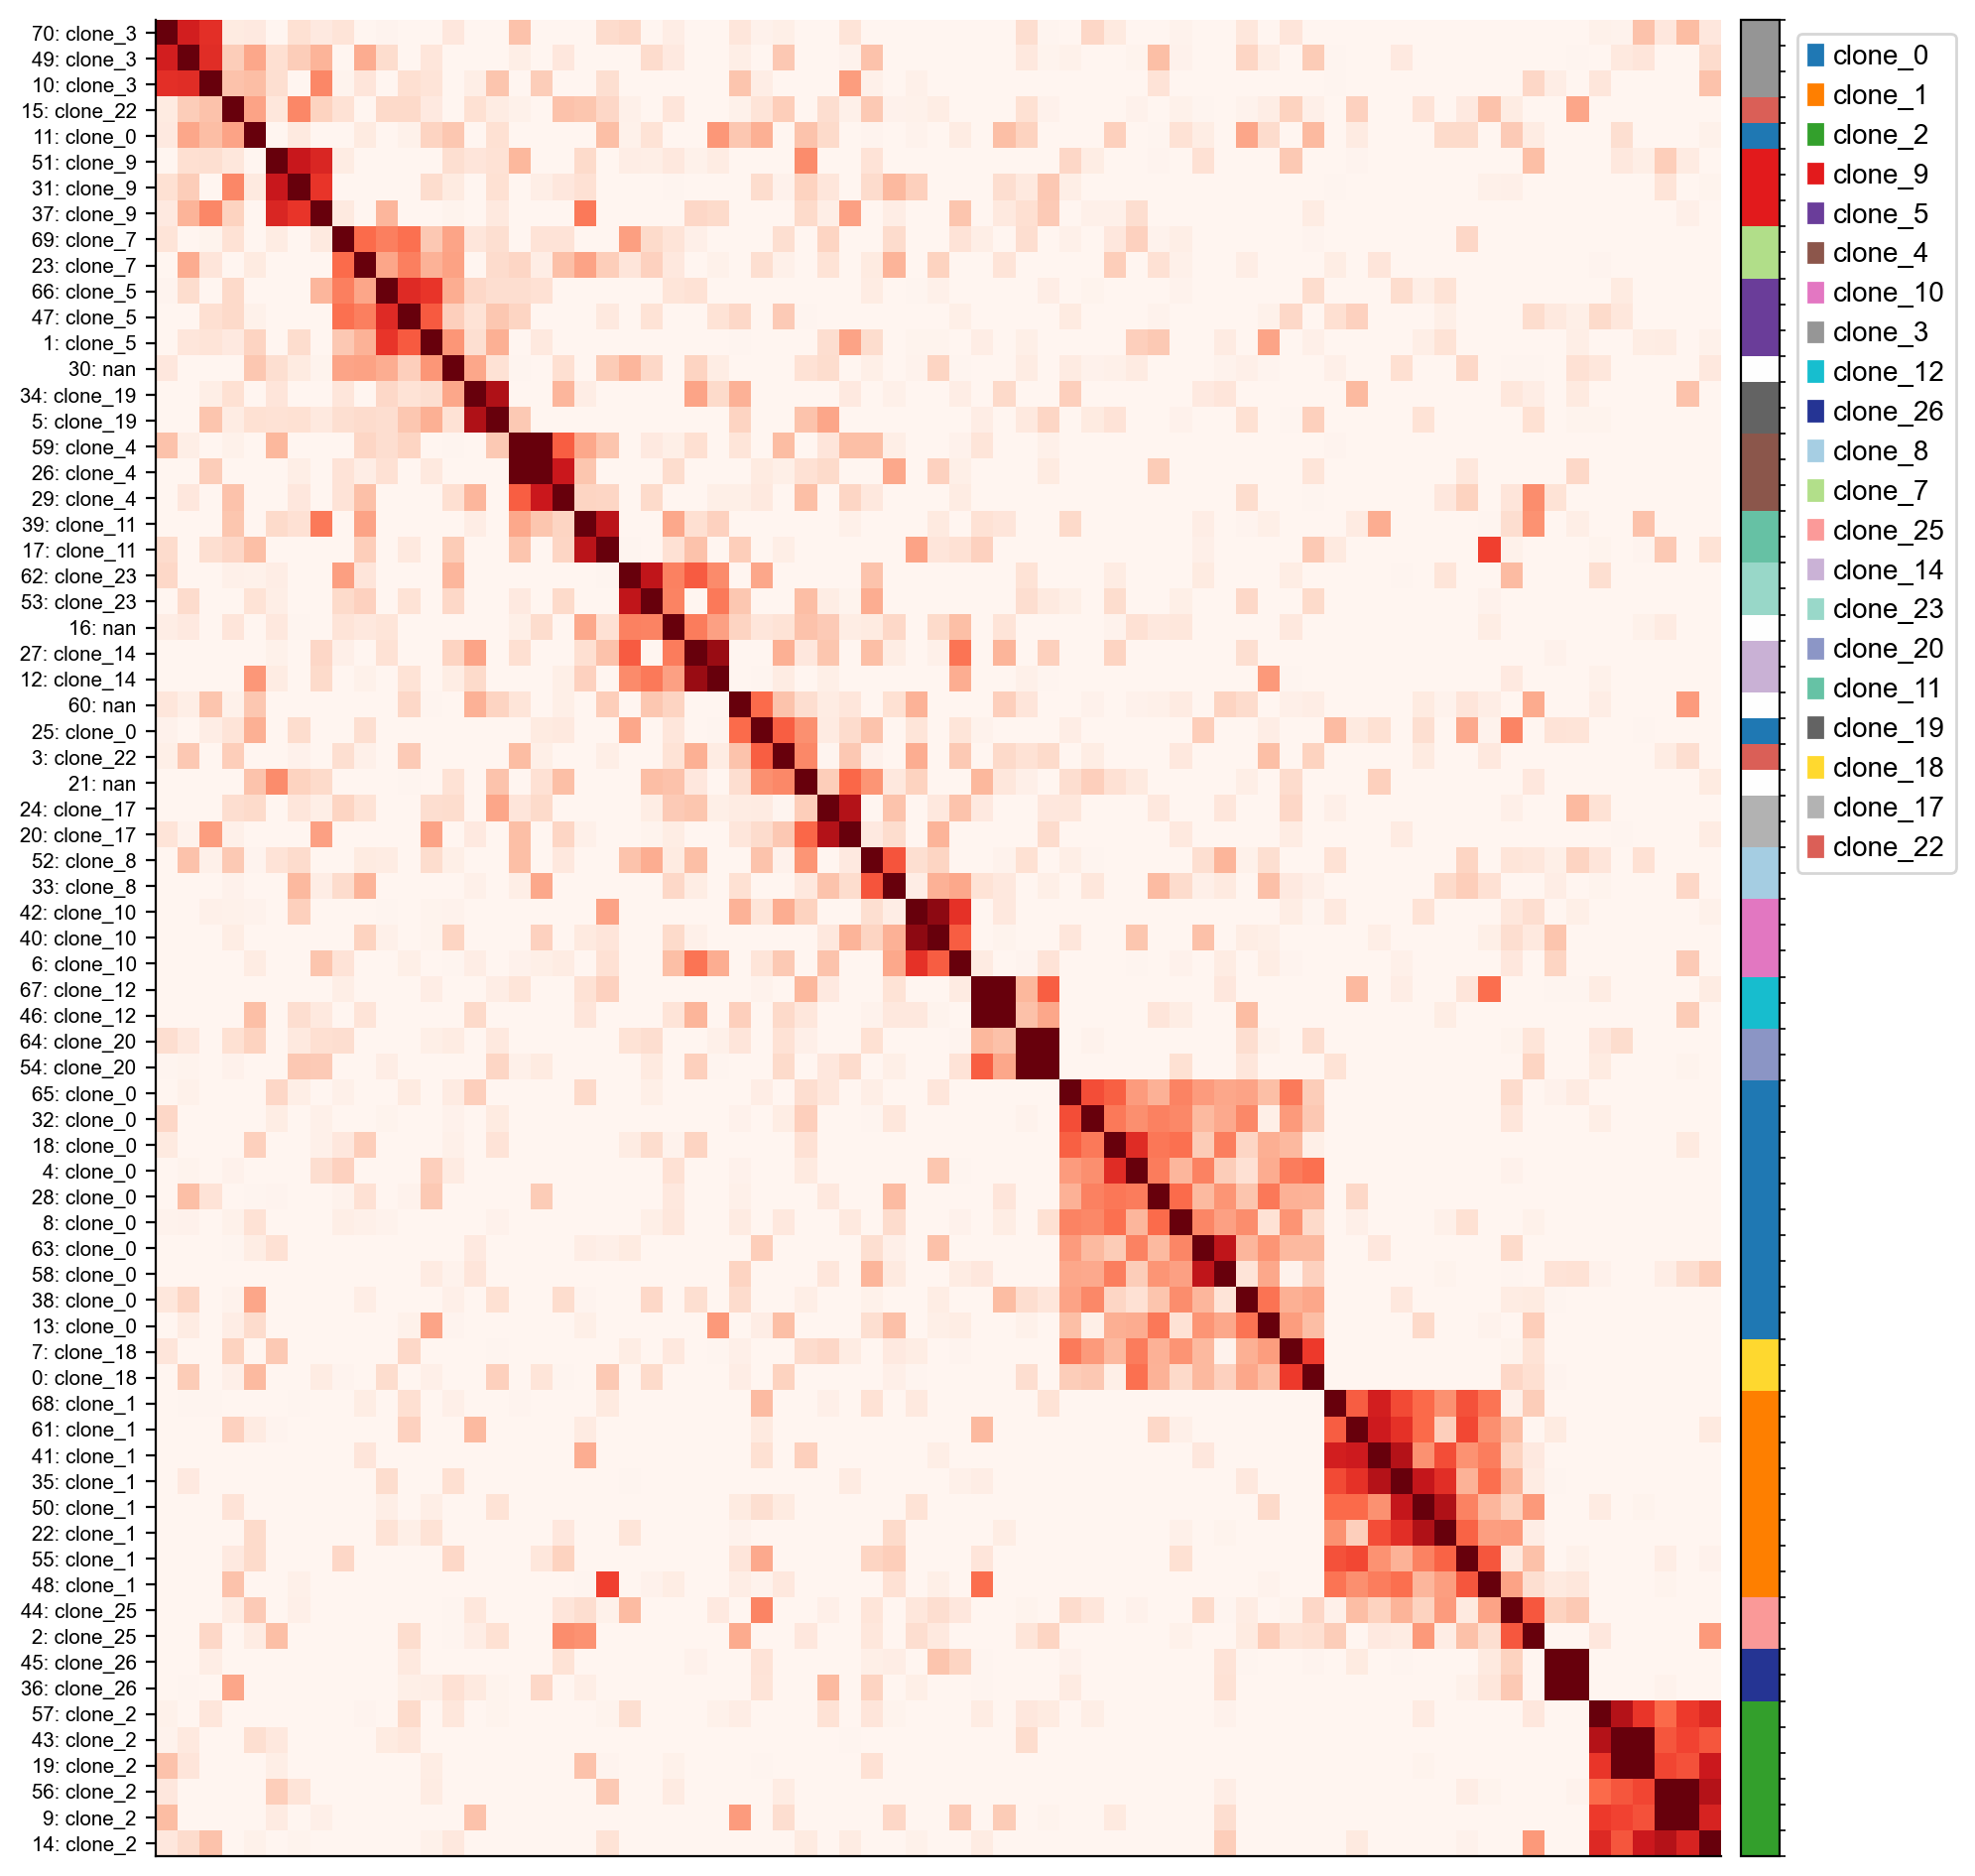

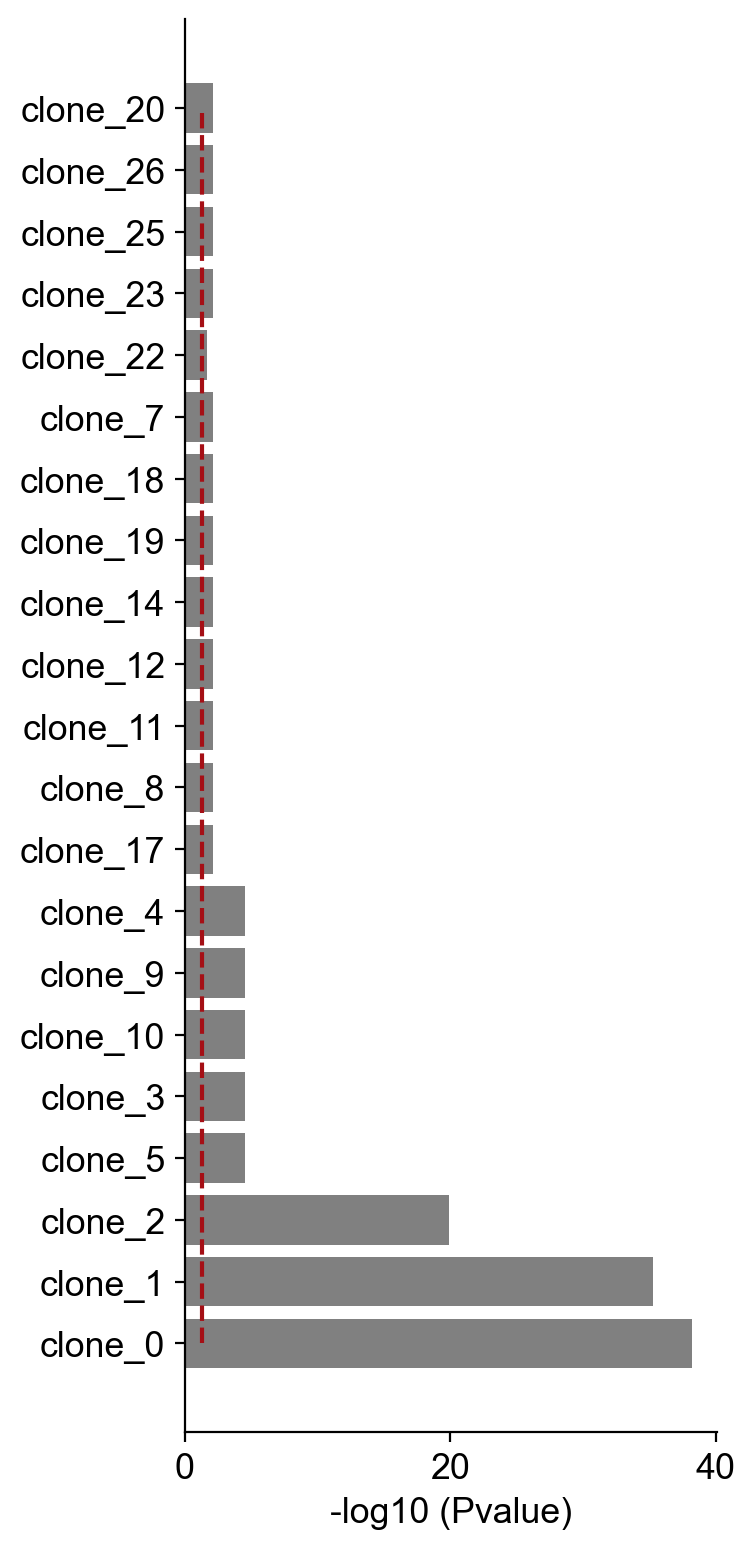

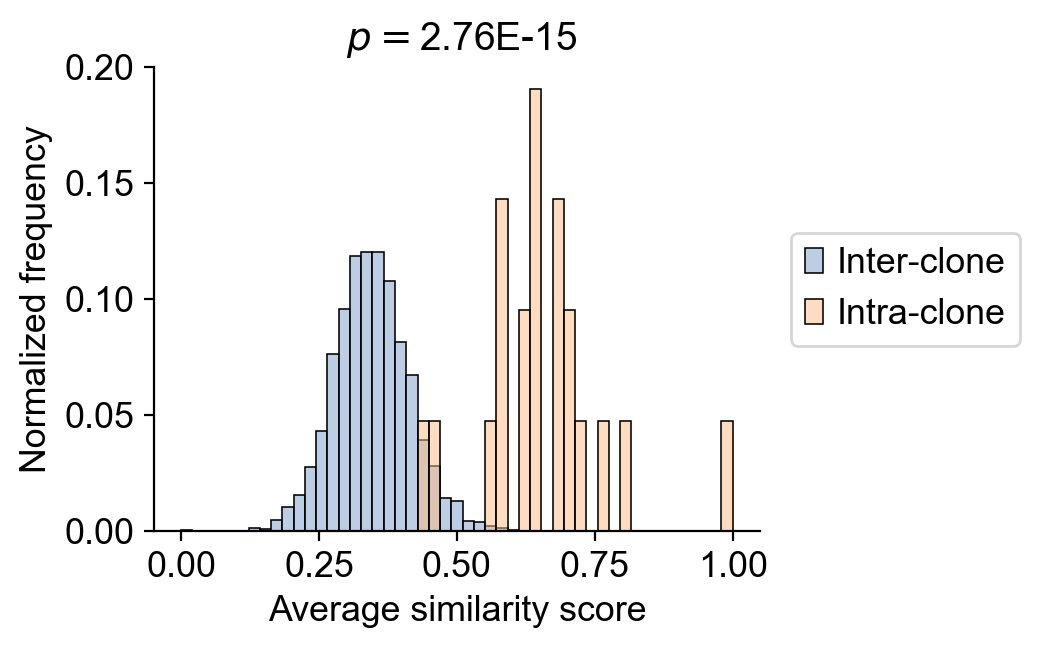

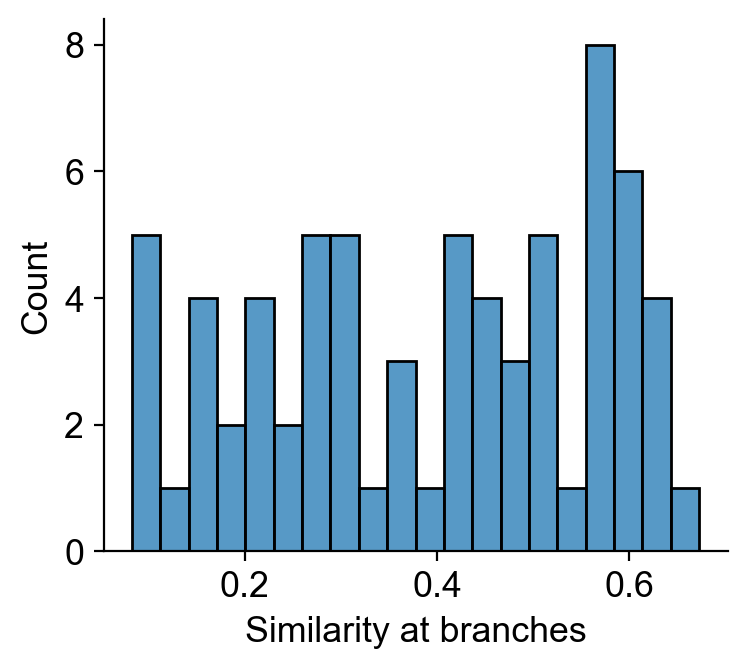

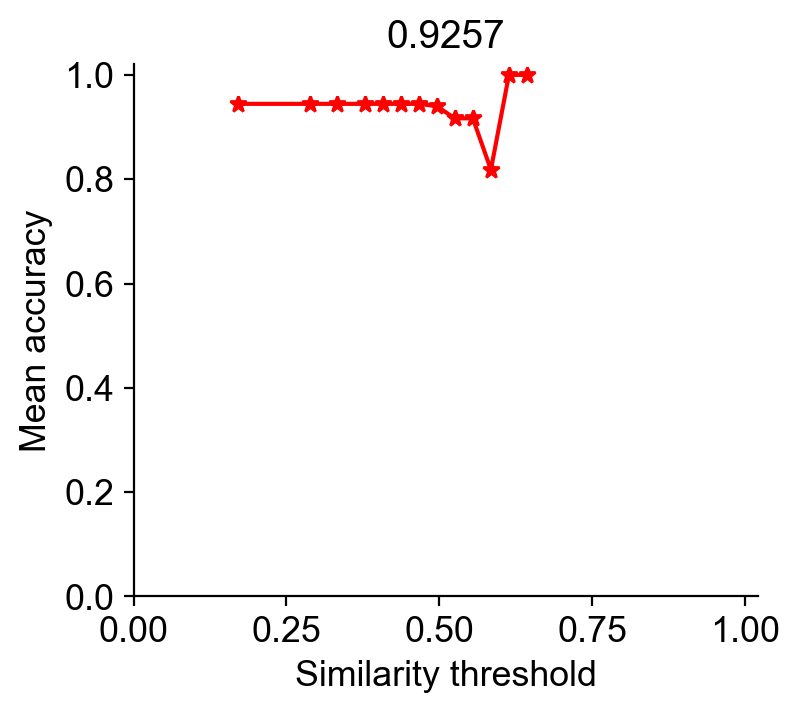

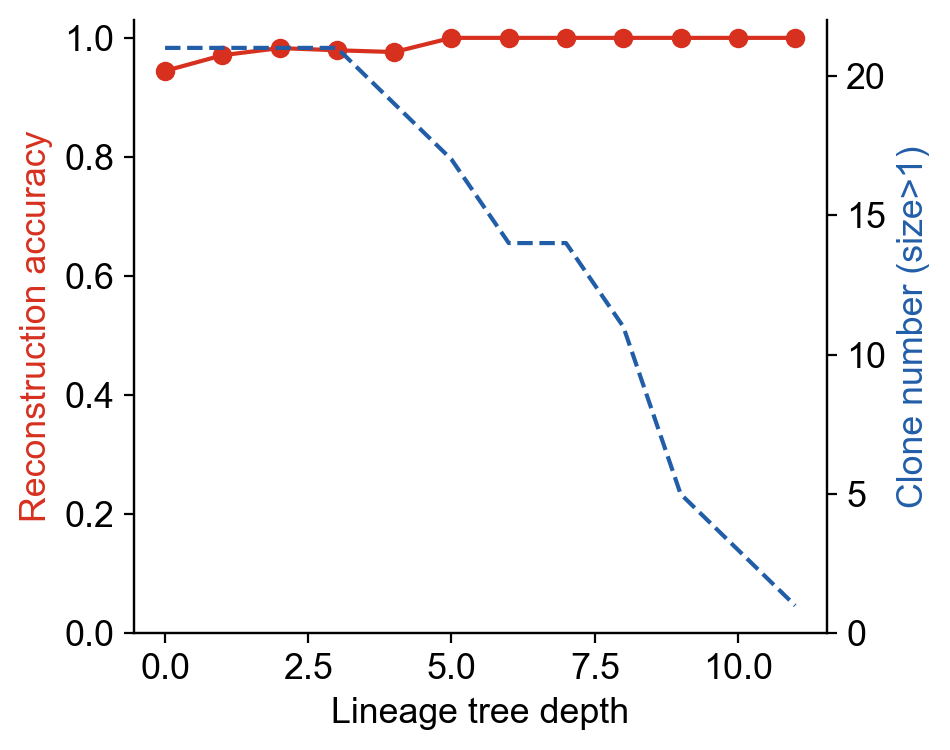

In [5]:
adata_final,stat_out=methyltree.analysis.comprehensive_lineage_analysis(out_dir,data_path,save_data_des,clone_key,adata_orig=adata,
                                                        clone_color_dict=None,#heatmap_additional_key_list=['CD150_high'],
                                                        compute_similarity=False,
                                                        update_sample_info=True,
                                                        # correct the correlation bias
                                                        similarity_correction=True,
                                                        # remove cell-type specific DNA methylation signals
                                                        remove_celltype_signal=False,cell_type_key=None,
                                                        # optimize the lineage tree
                                                        optimize_tree=False,optimize_background_cutoff=0.4,
                                                        # better heatmap visualization
                                                        heatmap_vmax_percentile=99.9,heatmap_vmin_percentile=60,heatmap_figsize=(10, 9.5),heatmap_show_label=True,
                                                        heatmap_show_legend=True,heatmap_additional_key_list=None,heatmap_fontsize=8,
                                                        # related to saving figures
                                                        fig_dir=figure_path,data_des=data_des,
                                                        # coarse-graining
                                                        perform_coarse_graining=False,coarse_grain_vmin=None,coarse_grain_figsize=(6, 5),
                                                        # infer the clones based on similarity cutoff
                                                        perform_clone_inference=False,clone_inference_threshold=0.6,
                                                        perform_memory_analysis=True,
                                                        perform_depth_analysis=True,)

Replot the heatmap using pre-computed adata. Using the additional_key_list variable to show more features

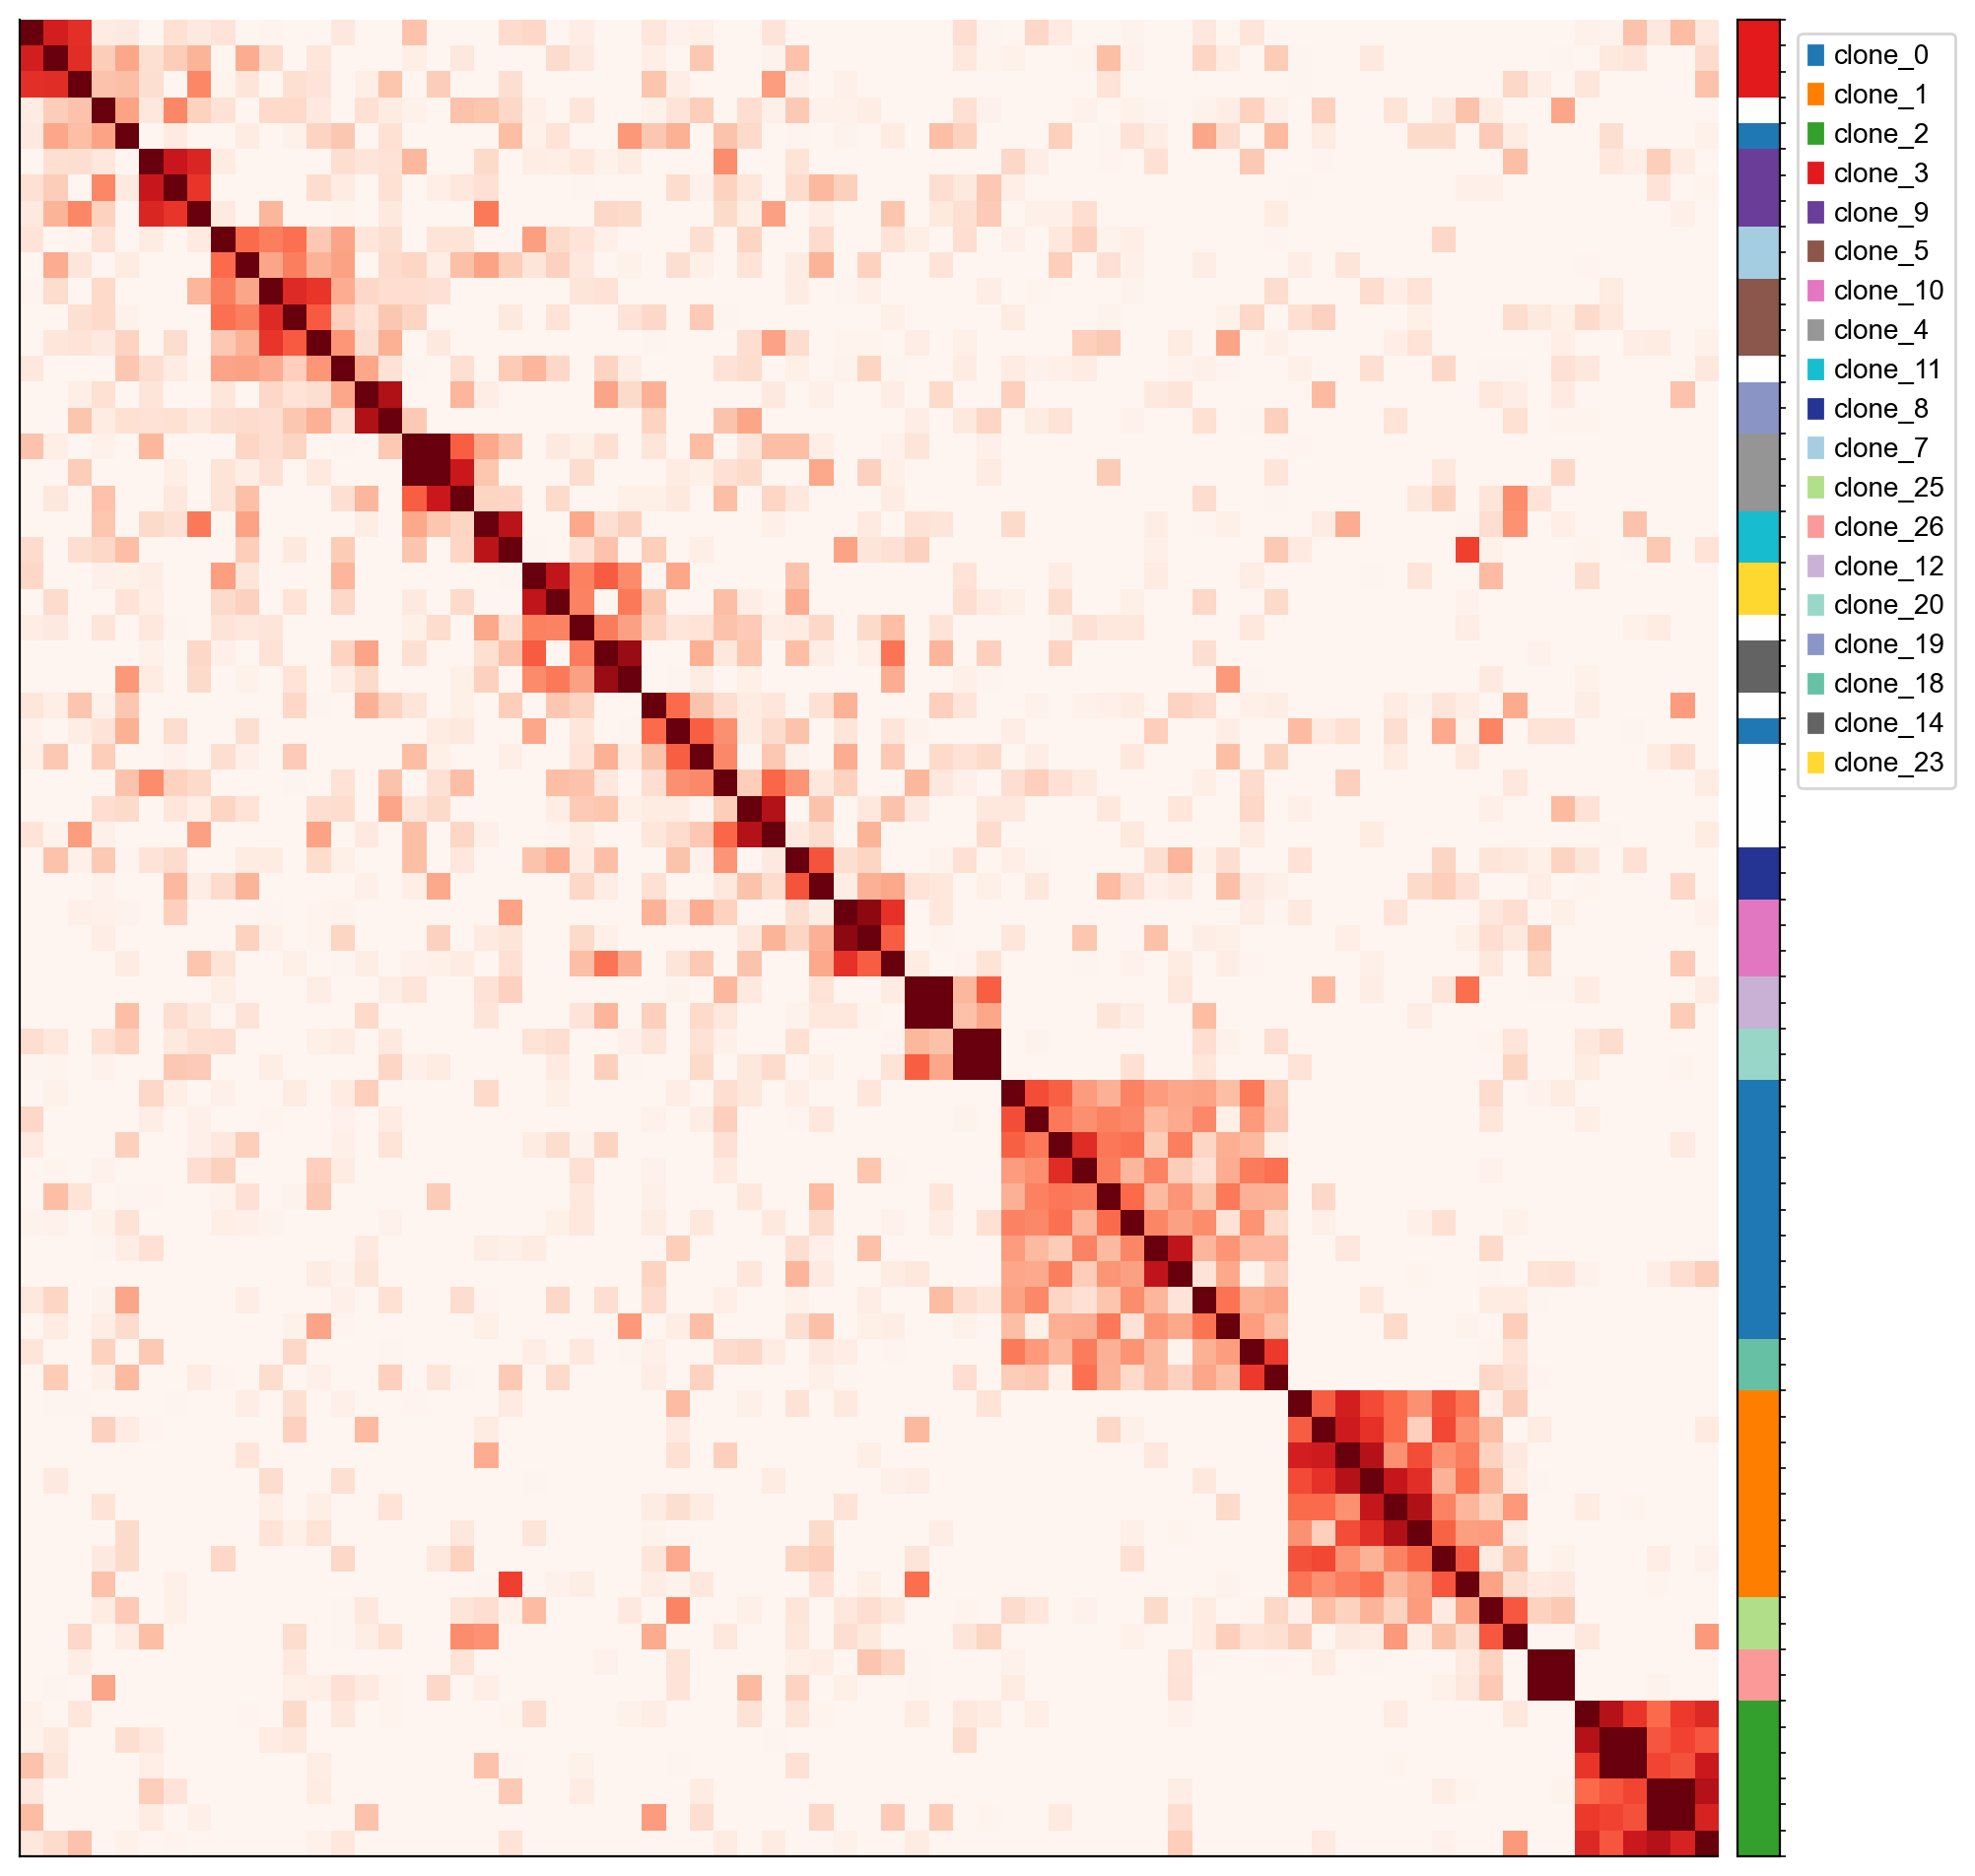

In [6]:
methyltree.plotting.plot_similarity_heatmap_with_multiple_colorbars(adata_final,additional_key_list=None,heatmap_vmax_percentile=99.9,heatmap_vmin_percentile=60,)

creating directory figure for saving figures
Time points with clonal info: []
Results saved as dictionary at adata.uns['fate_coupling_X_similarity']

      /-BM_HSC_2
   /-|
--|   \-BM_HSC_0
  |
   \-BM_HSC_1


Tree node '' (0x2aa17a8e)

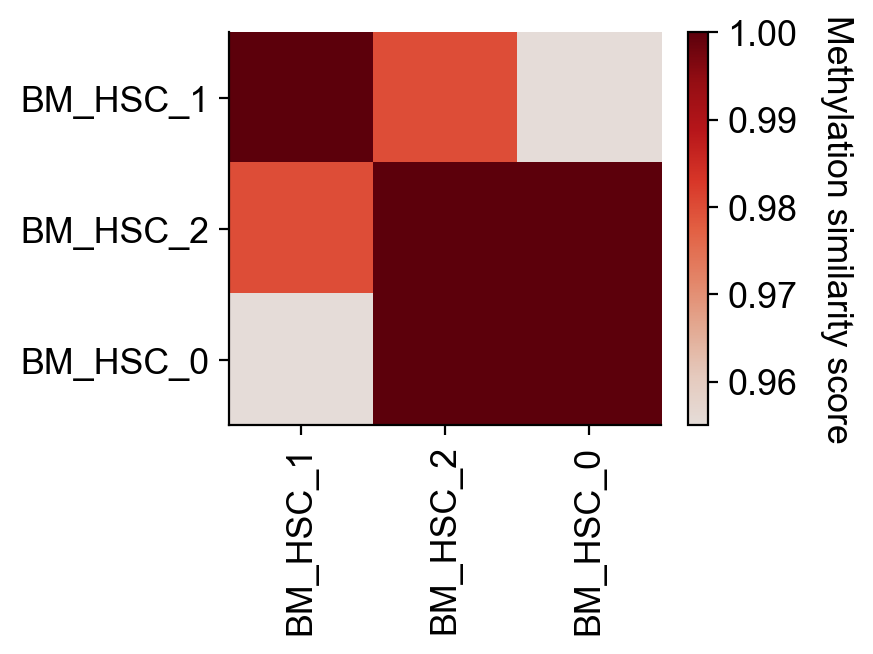

In [7]:
methyltree.analysis.coarse_grain_analysis(adata_final,clone_key='celltype',normalized_X_similarity=True)

# Downstream analysis

## Low-dimensional embedding

100%|██████████| 71/71 [00:00<00:00, 748230.11it/s]


reorder clones
Time points with clonal info: ['0']
spectrum embedding (with normalization)
use pre-set clone order


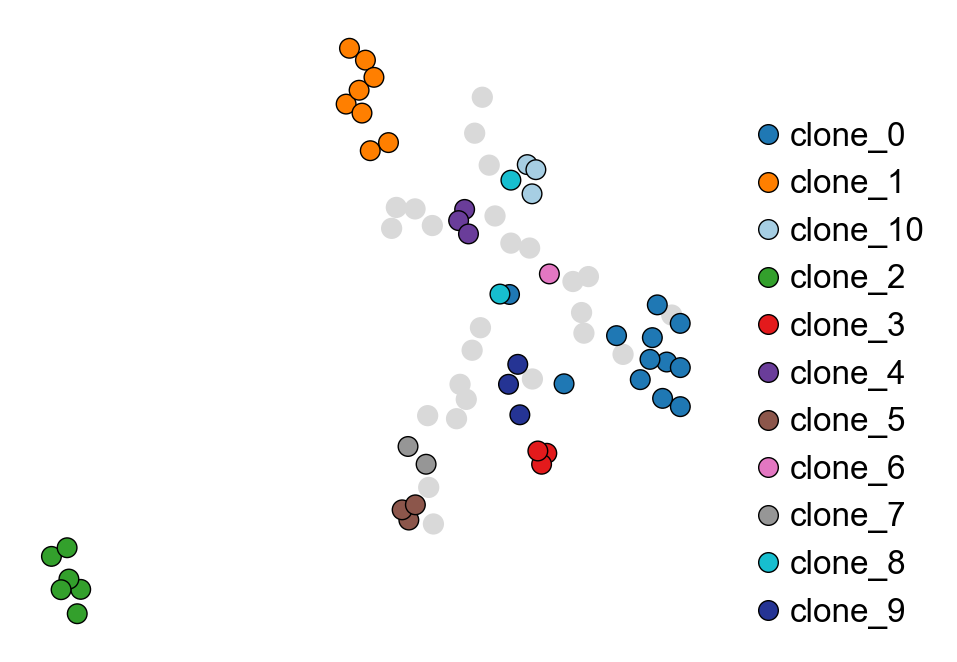

In [8]:
sel_clone_set=['clone_0','clone_1','clone_2','clone_3','clone_4','clone_5','clone_6','clone_7','clone_8','clone_9','clone_10']
adata_new=methyltree.analysis.embedding_analysis(adata_final,clone_key,
                            UMAP_parameters=[10,10,0.3],sel_clone_set=sel_clone_set,
                            clone_prefix=None,figure_path=figure_path,
                            title='',
                            fontsize=13,marker_size=50)


## Compute support value of the tree

Compute the support of the tree to estimate the robustness of each branch, which can be used to call clones later

In [9]:
methyltree.lineage.bootstrap_lineage_tree(adata_final,out_dir,
    save_data_des,
    clone_key=clone_key,
    cell_type_key=None, # this is not used unless remove_celltype_signal=True
    num_iterations=10,  
    sample_fraction=0.8,  
    similarity_correction=True,
    remove_celltype_signal=False,
    heatmap_ordering_method='UPGMA',
    recompute=False,
    cores=64)

num_iterations : 0
num_iterations : 5
num_iterations : 2
num_iterations : 4
num_iterations : 9
num_iterations : 7
num_iterations : 1
num_iterations : 6
num_iterations : 8
num_iterations : 3
adata shape:  (71, 85906)
re-compute similarity matrix
adata shape:  (71, 85906)
re-compute similarity matrixUse correlation for similarity

Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute similarity matrix
Use correlation for similarity
adata shape:  (71, 85906)
re-compute

  0%|          | 5/1000 [00:00<00:02, 395.91it/s]


correct similarity: outer loop 0;  current epsilon 0.05
Use fast/analytical correction method


  0%|          | 4/1000 [00:00<00:00, 2039.54it/s]

std: 0.015
Reconstruction method: UPGMA


Tree node '1.00' (0x2d29d42e)

## Visualize the lineage tree with support values
Better visualization requires another notebook using `viewtree` package. The leaf nodes are name as 'cell_index'\_'cell_type'\_'clone_id'

Note that this tree should have the same topology as the one computed using the full data, and used for order the similarity matrix.

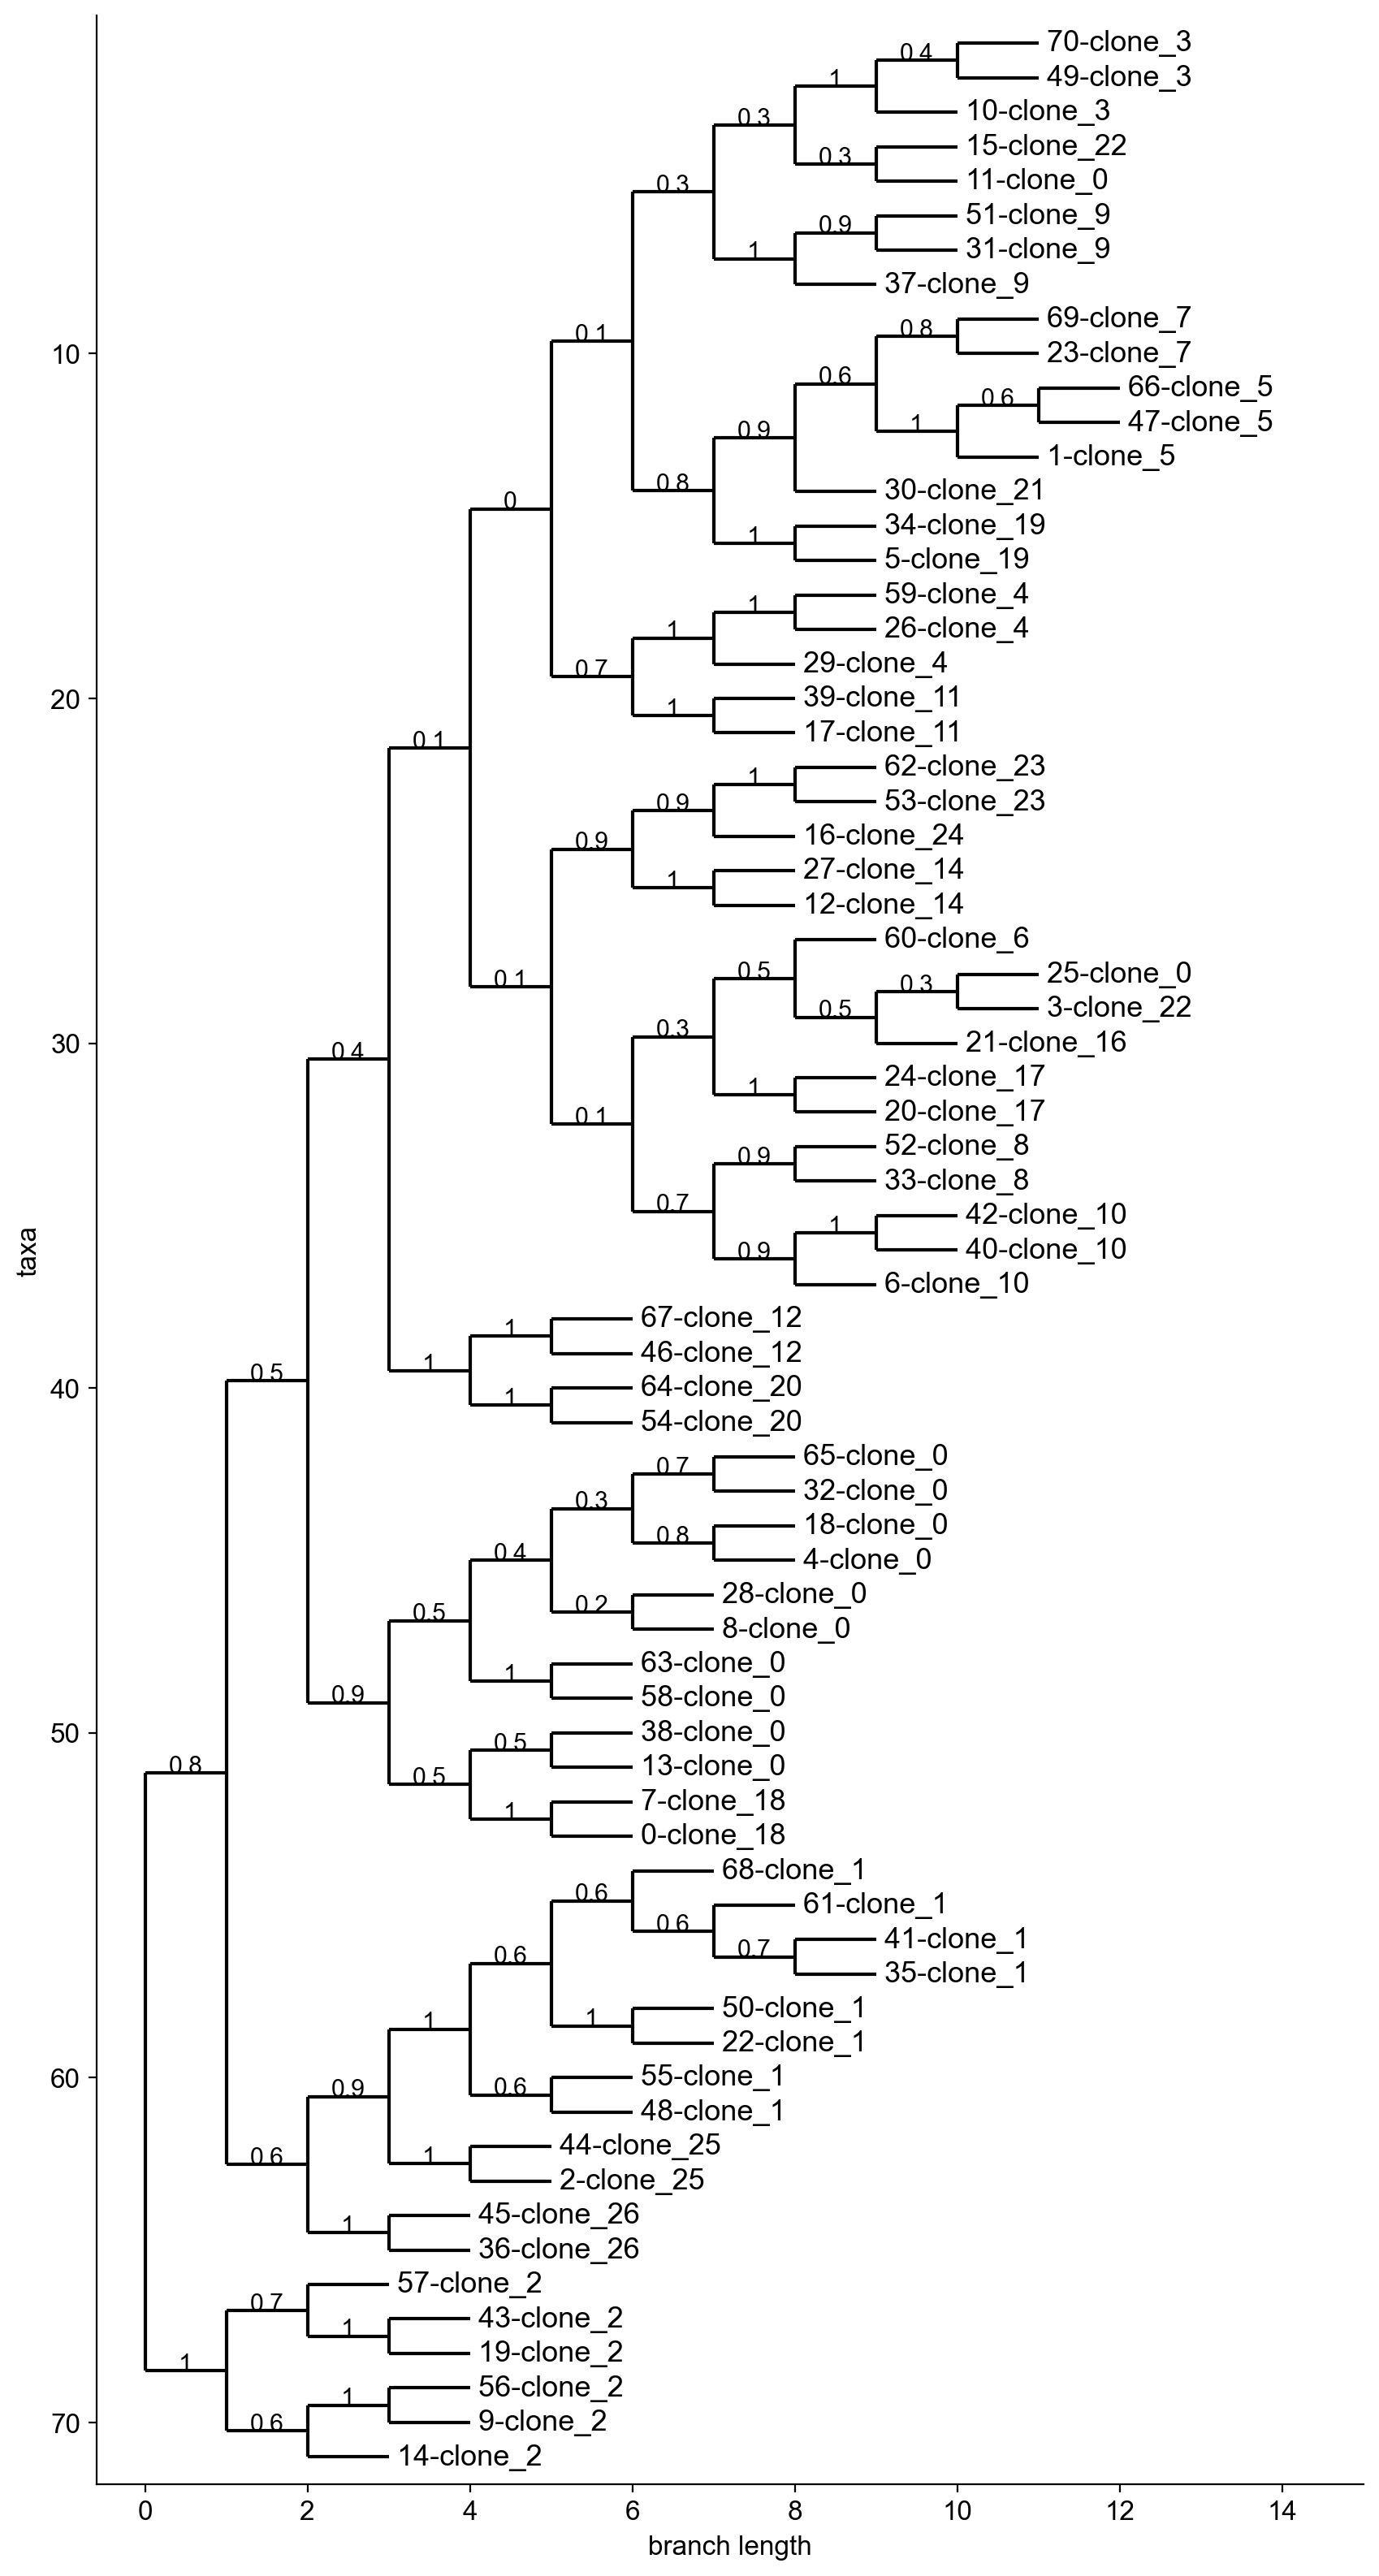

<Figure size 600x400 with 0 Axes>

In [10]:
cs.settings.set_figure_params(fontsize=13)
method='UPGMA'
my_tree_path=f"{out_dir}/lineage_tree_{clone_key}_{save_data_des}_{method}_support.txt"
methyltree.plotting.plot_tree_with_support(my_tree_path,leaf_name_map=None,figsize=(10,20))#leaf_name_map=lambda x: x.split('-')[-1],figsize=(20,50))
plt.savefig(f'{figure_path}/lineage_tree_support.pdf')